In [6]:
# ============================================================
# Analyzing the Impact of Weather and Temporal Factors on Bike-Sharing Demand
# (Linear Regression for Effect-Size Estimation — NOT forecasting)
# ============================================================

# -------------------------------
# 1) IMPORTS & DATA COLLECTION
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")

# -------------------------------
# 2) LOAD DATA (USER INPUT)
# ------------------------------
file_path = r"C:\Users\USER PC\Downloads\new data\SeoulBikeData.csv"
bike_data = pd.read_csv(file_path, encoding='unicode_escape')

print("Shape:", bike_data.shape)
print(bike_data.head())

# -------------------------------
# 3) DATA PREPROCESSING
# -------------------------------

# Convert 'Date' column to datetime format
bike_data['Date'] = pd.to_datetime(bike_data['Date'], format='%d/%m/%Y')

# Step 1: Check for missing values
print("\nMissing values per column:")
print(bike_data.isnull().sum())

# Step 2: Check for outliers in numerical columns (using IQR)
numeric_cols = bike_data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = bike_data[col].quantile(0.25)
    Q3 = bike_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((bike_data[col] < lower) | (bike_data[col] > upper)).sum()
    print(f"{col}: {outliers} potential outliers")

# Step 3: Extract Month and Day of the Week from Date
bike_data['Month'] = bike_data['Date'].dt.month
bike_data['DayOfWeek'] = bike_data['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Step 4: Convert 'Functioning Day' to numeric (1=Yes, 0=No)
if 'Functioning Day' in bike_data.columns:
    bike_data['Functioning Day'] = bike_data['Functioning Day'].map({'No': 0, 'Yes': 1}).astype(int)

print("\nData preprocessing completed. Sample data:")
print(bike_data[['Date','Month','DayOfWeek','Functioning Day','Rented Bike Count']].head())

Shape: (8760, 14)
         Date  Rented Bike Count  Hour  Temperature(C)  Humidity(%)  \
0  01/12/2017                254     0            -5.2           37   
1  01/12/2017                204     1            -5.5           38   
2  01/12/2017                173     2            -6.0           39   
3  01/12/2017                107     3            -6.2           40   
4  01/12/2017                 78     4            -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(C)  \
0               2.2              2000                     -17.6   
1               0.8              2000                     -17.6   
2               1.0              2000                     -17.7   
3               0.9              2000                     -17.6   
4               2.3              2000                     -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holid


=== Exploratory Data Analysis ===


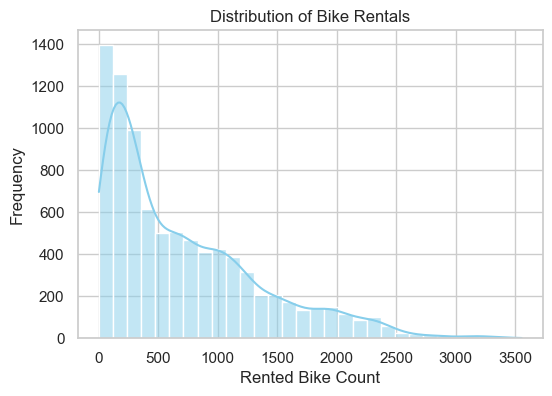

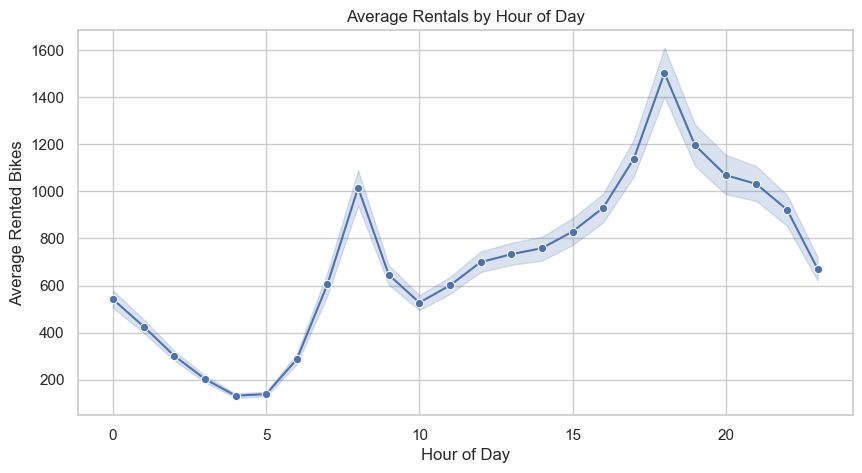

In [14]:
# -------------------------------
# 4) EXPLORATORY DATA ANALYSIS (EDA)
# -------------------------------
print("\n=== Exploratory Data Analysis ===")

# 4a) Distribution of bike rentals
#Shows how often each rental count occurs
plt.figure(figsize=(6,4))
sns.histplot(bike_data['Rented Bike Count'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Bike Rentals")
plt.xlabel("Rented Bike Count")
plt.ylabel("Frequency")
plt.show()

# 4b) Average rentals by hour
#Plots the average number of bikes rented per hour
plt.figure(figsize=(10,5))
sns.lineplot(x="Hour", y="Rented Bike Count", data=bike_data, estimator="mean", marker="o")
plt.title("Average Rentals by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rented Bikes")
plt.show()

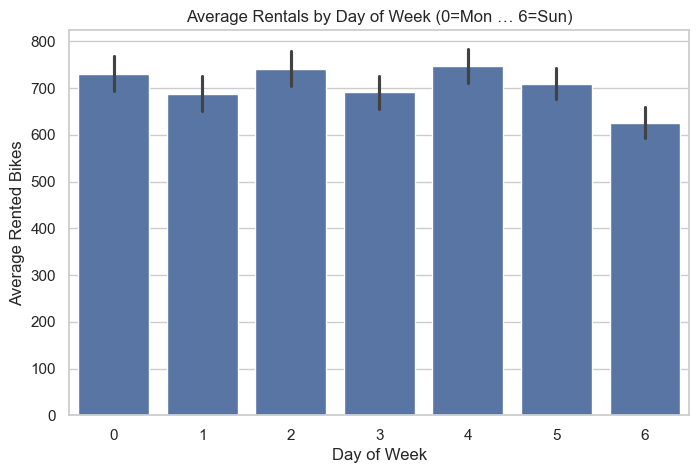

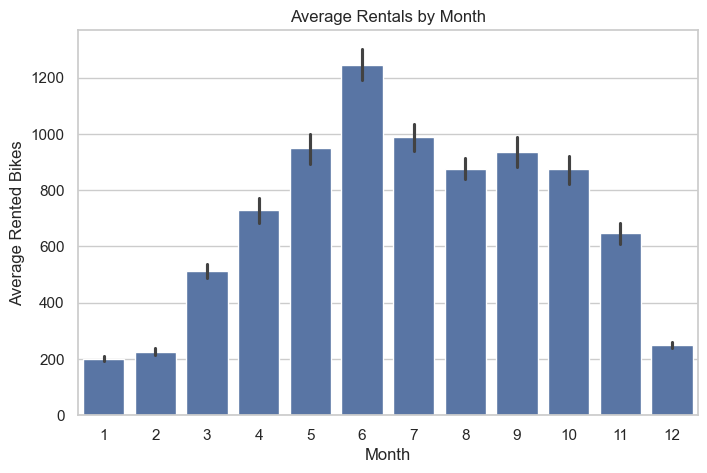

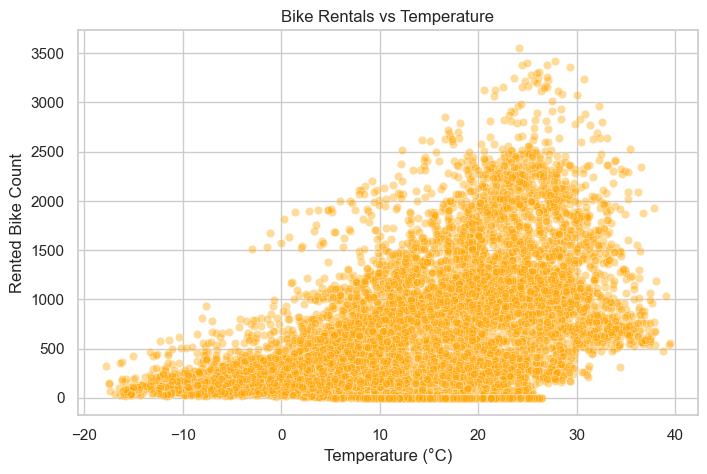

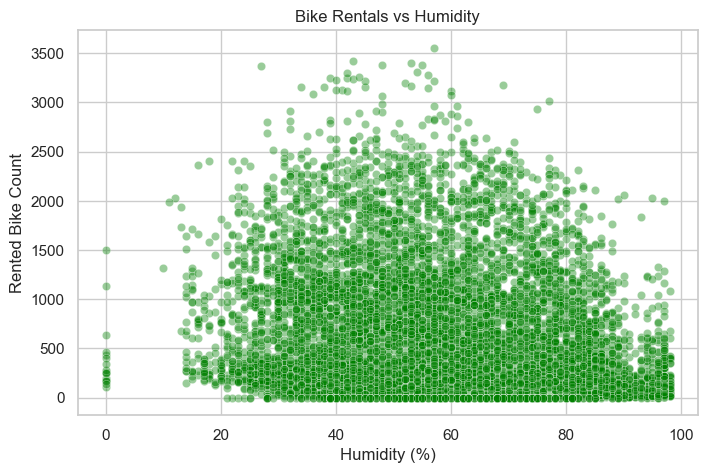

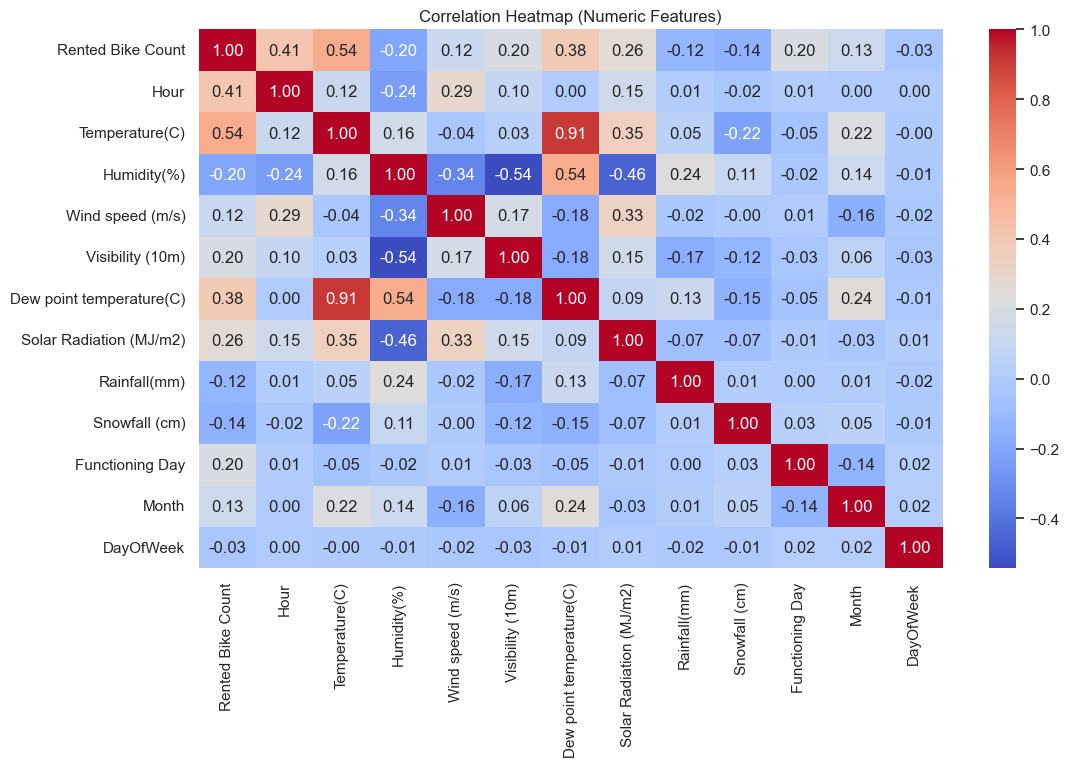

In [5]:
# 4c) Average rentals by weekday
#Shows average rentals per day (Monday-Sunday)
plt.figure(figsize=(8,5))
sns.barplot(x="DayOfWeek", y="Rented Bike Count", data=bike_data, estimator=np.mean, hue=None)
plt.title("Average Rentals by Day of Week (0=Mon … 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Average Rented Bikes")
plt.show()

# 4d) Average rentals by month
#Shows average rentals per month
plt.figure(figsize=(8,5))
sns.barplot(x="Month", y="Rented Bike Count", data=bike_data, estimator=np.mean, hue=None)
plt.title("Average Rentals by Month")
plt.xlabel("Month")
plt.ylabel("Average Rented Bikes")
plt.show()

# 4e) Scatterplots for weather effects
plt.figure(figsize=(8,5))
sns.scatterplot(x="Temperature(C)", y="Rented Bike Count", data=bike_data, alpha=0.4, color='orange')
plt.title("Bike Rentals vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rented Bike Count")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x="Humidity(%)", y="Rented Bike Count", data=bike_data, alpha=0.4, color='green')
plt.title("Bike Rentals vs Humidity")
plt.xlabel("Humidity (%)")
plt.ylabel("Rented Bike Count")
plt.show()

# 4f) Correlation heatmap
#Shows correlation between numeric variables
plt.figure(figsize=(12,7))
sns.heatmap(bike_data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


=== Linear Regression Modeling ===

--- Feature Coefficients ---
                     Feature  Coefficient
9            Functioning Day   862.164487
0                       Hour    27.900479
1             Temperature(C)    26.153134
10                     Month    14.411373
3           Wind speed (m/s)    11.909032
5   Dew point temperature(C)     5.168926
4           Visibility (10m)     0.018969
8              Snowfall (cm)    -0.778364
2                Humidity(%)    -8.546945
11                 DayOfWeek   -10.498313
7               Rainfall(mm)   -62.176283
6    Solar Radiation (MJ/m2)   -75.204430


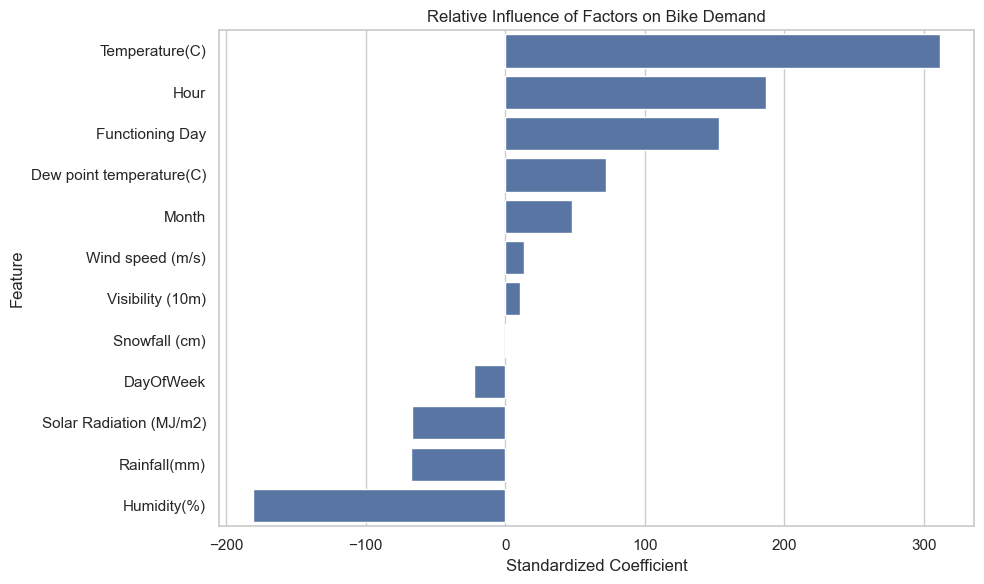

In [16]:
# -------------------------------
# 5) LINEAR REGRESSION MODEL (USER-FRIENDLY)
# -------------------------------
print("\n=== Linear Regression Modeling ===")

# -------------------------------
# Step 1: Define target and features
# -------------------------------
target = 'Rented Bike Count'  # what we want to predict
features = [
    'Hour', 'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(C)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    'Functioning Day', 'Month', 'DayOfWeek'
]

X = bike_data[features]
y = bike_data[target]

# -------------------------------
# Step 2: Split dataset into training and test sets (80/20)
# -------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Step 3: Fit linear regression model
# -------------------------------
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# -------------------------------
# Step 4: Show effect of each feature (unstandardized coefficients)
# -------------------------------
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lin_model.coef_
}).sort_values('Coefficient', ascending=False)

print("\n--- Feature Coefficients ---")
print(coefficients)

# -------------------------------
# Step 5: Standardize features for relative effect sizes
# -------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # scale features to mean=0, std=1

lin_model_std = LinearRegression()
lin_model_std.fit(X_scaled, y)

std_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Standardized Coefficient': lin_model_std.coef_
}).sort_values('Standardized Coefficient', ascending=False)

# -------------------------------
# Step 6: Plot standardized coefficients (relative influence)
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

#Shows relative influence of features in a bar chart
plt.figure(figsize=(10,6))
sns.barplot(
    x='Standardized Coefficient',
    y='Feature',
    data=std_coefficients,
    hue=None  # avoids FutureWarning in Seaborn v0.14+
)
plt.title("Relative Influence of Factors on Bike Demand")
plt.xlabel("Standardized Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


--- Model Performance ---
Mean Absolute Error (MAE) : 336.07
Root Mean Squared Error (RMSE): 450.11
R² Score: 0.514


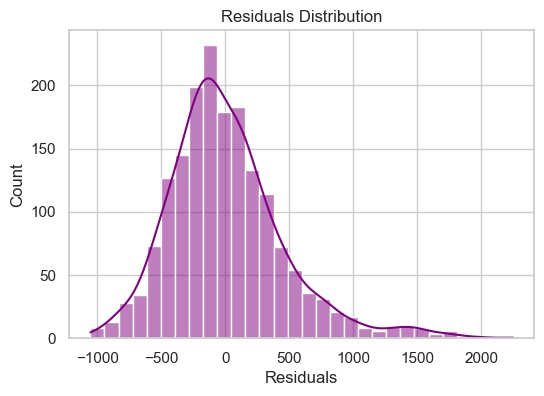


--- Variance Inflation Factors (VIF) ---
                     Feature         VIF
5   Dew point temperature(C)  113.546791
1             Temperature(C)   85.880542
2                Humidity(%)   20.296449
6    Solar Radiation (MJ/m2)    2.018880
4           Visibility (10m)    1.604594
3           Wind speed (m/s)    1.285128
0                       Hour    1.187779
10                     Month    1.137889
8              Snowfall (cm)    1.112405
7               Rainfall(mm)    1.085718
9            Functioning Day    1.022404
11                 DayOfWeek    1.011373

✅ Analysis completed! You can now interpret the results and plots.


In [7]:
# -------------------------------
# 6) MODEL DIAGNOSTICS
# -------------------------------
y_pred = lin_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Performance ---")
print(f"Mean Absolute Error (MAE) : {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()

# -------------------------------
# 7) MULTICOLLINEARITY CHECK (VIF)
# -------------------------------
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    X_vif = X_train.copy()
    X_vif = X_vif.assign(constant=1.0)
    vifs = []
    for i in range(len(X_vif.columns)-1):
        vifs.append({'Feature': X_vif.columns[i],
                     'VIF': variance_inflation_factor(X_vif.values, i)})
    vif_df = pd.DataFrame(vifs).sort_values('VIF', ascending=False)
    print("\n--- Variance Inflation Factors (VIF) ---")
    print(vif_df)
except:
    print("VIF check skipped (statsmodels not installed)")

print("\n✅ Analysis completed! You can now interpret the results and plots.")
